In [1]:
import gzip
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from google.colab import files
from collections import Counter
from sklearn.model_selection import train_test_split


In [2]:
uploaded=files.upload()

Saving flatland_train.data to flatland_train.data


In [3]:
def evaluate(path, model):
    X, y = pickle.load(gzip.open(path, 'rb'))
    y[y != 0] -= 2
    X = X / 255.
    acc = np.mean(model(X).numpy().argmax(axis=1) == y)
    return acc

In [4]:
path = 'flatland_train.data'
X, y = pickle.load(gzip.open(path, 'rb')) #(10000,50,50)

#data pre-proc
y[y != 0] -= 2 #jei klasė ne nulis, atimk iš jos 2, labels from (0, 4)
X = X / 255. #normalizuojam data, kad pixeliai butu rezyje (0,1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
X_train.shape

(7000, 50, 50)

In [7]:
X_test.shape

(3000, 50, 50)

In [8]:
y_train

array([1., 0., 3., ..., 3., 1., 4.])

In [9]:
for i in range (5): #nes eilutėje turime 5 elementus, sužinome kuriuose indeksuose kiekvienos grupės elementai atsiranda
  print (np.where(y_train ==i)[0][0])

1
0
9
2
7


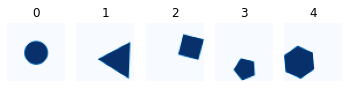

In [10]:
for i in range (5): #atspausdiname po elementą iš kiekvienos grupės
  idx=np.where(y_train==i)[0][0]
  plt.subplot(2,5,i+1)
  plt.imshow(X_train[idx], cmap='Blues')
  plt.title(i)
  plt.axis('off')

In [11]:
Counter(y) #suskaičiuojame, kiek elementų yra kiekvienoje grupėje

Counter({0.0: 1381, 1.0: 2853, 2.0: 1868, 3.0: 2137, 4.0: 1761})

In [12]:
y

array([2., 4., 3., ..., 4., 4., 3.])

In [13]:
X_train[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# **DNN**

Pačiame pradiniame modelyje išbandžiau visokius optimizer'ius, pavyzdžiui STG, Adam (nepriskiriant learning_rate), tačiau su jais nesugebėjau parinkti tokio learning_rate, kad val_loss nešokinėtų, todėl pasirinkau dirbti su Adam optimizacija, priskiriant learning_rate 3e-4.
Taip pat šitame modelyje matome ganėtinai didelį sluoksnių skaičių, tačiau parenkant mažesnį gauname labai mažą tikslumą (bent jau kiek aš sugebėjau išbandyti).
Gautą modelį taip pat sunku pavadinti geru, kai yra toks didelis skirtumas tarp loss ir val_loss, labiau panašu į overfit'ą.

In [14]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(50,50))) #(50,50), nes toks yra objektų dydis
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(75, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(25, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=3e-4), 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2500)              0         
                                                                 
 dense (Dense)               (None, 100)               250100    
                                                                 
 dense_1 (Dense)             (None, 75)                7575      
                                                                 
 dense_2 (Dense)             (None, 50)                3800      
                                                                 
 dense_3 (Dense)             (None, 25)                1275      
                                                                 
 dense_4 (Dense)             (None, 10)                260       
                                                                 
Total params: 263,010
Trainable params: 263,010
Non-trai

In [15]:
loss = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30)

Epoch 1/30
219/219 [==============================] - 4s 6ms/step - loss: 1.5258 - accuracy: 0.3686 - val_loss: 1.3151 - val_accuracy: 0.4743
Epoch 2/30
219/219 [==============================] - 1s 5ms/step - loss: 1.1782 - accuracy: 0.5104 - val_loss: 1.1320 - val_accuracy: 0.5133
Epoch 3/30
219/219 [==============================] - 1s 5ms/step - loss: 1.0607 - accuracy: 0.5601 - val_loss: 1.0365 - val_accuracy: 0.5710
Epoch 4/30
219/219 [==============================] - 1s 5ms/step - loss: 0.9105 - accuracy: 0.6269 - val_loss: 0.9115 - val_accuracy: 0.6100
Epoch 5/30
219/219 [==============================] - 1s 5ms/step - loss: 0.7858 - accuracy: 0.6797 - val_loss: 0.8232 - val_accuracy: 0.6530
Epoch 6/30
219/219 [==============================] - 1s 5ms/step - loss: 0.6918 - accuracy: 0.7236 - val_loss: 0.7755 - val_accuracy: 0.6633
Epoch 7/30
219/219 [==============================] - 1s 5ms/step - loss: 0.6240 - accuracy: 0.7516 - val_loss: 0.7392 - val_accuracy: 0.6893
Epoch 

In [16]:
pd.DataFrame(loss.history)[['loss', 'val_loss']]

,loss,val_loss
0,1.525790,1.315054
1,1.178233,1.131966
2,1.060670,1.036510
3,0.910458,0.911476
4,0.785776,0.823241
5,0.691849,0.775495
6,0.623951,0.739202
7,0.572282,0.683870
8,0.534230,0.663610
9,0.497227,0.664129


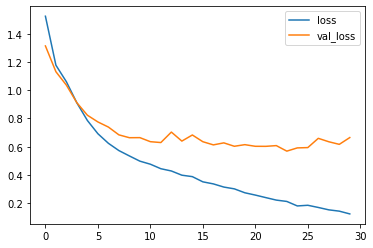

In [17]:
pd.DataFrame(loss.history)[['loss', 'val_loss']].plot()

# **Overfit**

Nors praeitas modelis ir yra panašus į overfit'ą, tačiau norėjau padaryti aiškesnį. Kaip matome, pridėjau daugiau sluoksnių ir padidinau density. Didinau sluoksnių skaičių tol, kol gavau, jog va_loss pradeda kilti (nuo apytiksliai 15 epochos)

In [18]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(50,50)))
model.add(keras.layers.Dense(1000, activation='relu'))
model.add(keras.layers.Dense(500, activation='relu'))
model.add(keras.layers.Dense(250, activation='relu'))
model.add(keras.layers.Dense(125, activation='relu'))
model.add(keras.layers.Dense(60, activation='relu'))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=3e-4), 
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 2500)              0         
                                                                 
 dense_5 (Dense)             (None, 1000)              2501000   
                                                                 
 dense_6 (Dense)             (None, 500)               500500    
                                                                 
 dense_7 (Dense)             (None, 250)               125250    
                                                                 
 dense_8 (Dense)             (None, 125)               31375     
                                                                 
 dense_9 (Dense)             (None, 60)                7560      
                                                                 
 dense_10 (Dense)            (None, 30)               

In [19]:
loss = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20
219/219 [==============================] - 2s 8ms/step - loss: 1.3604 - accuracy: 0.4330 - val_loss: 1.2096 - val_accuracy: 0.5000
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 1.0742 - accuracy: 0.5519 - val_loss: 1.0607 - val_accuracy: 0.5403
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.8271 - accuracy: 0.6540 - val_loss: 0.8311 - val_accuracy: 0.6527
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.6753 - accuracy: 0.7154 - val_loss: 0.7109 - val_accuracy: 0.6920
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.6009 - accuracy: 0.7527 - val_loss: 0.6613 - val_accuracy: 0.7137
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.5306 - accuracy: 0.7786 - val_loss: 0.6658 - val_accuracy: 0.7157
Epoch 7/20
219/219 [==============================] - 2s 7ms/step - loss: 0.4870 - accuracy: 0.7976 - val_loss: 0.6070 - val_accuracy: 0.7467
Epoch 

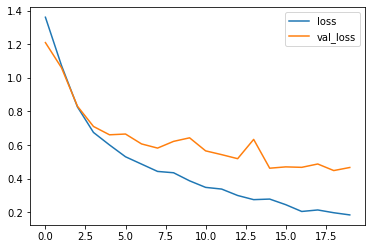

In [20]:
pd.DataFrame(loss.history)[['loss', 'val_loss']].plot()

# **Pridedam dropout**

Pridedam "dropout" komandą, kuri neleidžia modeliui overfit'int, išmetant neuronų sluoksnius. Čia vėl gi bandžiau keisti sluoksnių skaičių, density dydį, taip pat dropout dydį, nes su 0.2 gavau labai šokinėjančias loss ir val_loss kreives, jos taip pat neartėjo viena prie kitos. Vis dėlto, su šiuo modeliu nepavyko gauti labai tikslaus modelio.

In [21]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(50,50)))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=3e-4), 
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 2500)              0         
                                                                 
 dense_12 (Dense)            (None, 256)               640256    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)               

Taip pat čia pridedame batch_size funkciją, kuri pagreitina skaičiavimus, nes daro didesnius žingsnius.

In [22]:
loss = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=256)

Epoch 1/50
28/28 [==============================] - 1s 16ms/step - loss: 2.3016 - accuracy: 0.1413 - val_loss: 2.0905 - val_accuracy: 0.2563
Epoch 2/50
28/28 [==============================] - 0s 8ms/step - loss: 2.1217 - accuracy: 0.1880 - val_loss: 1.9644 - val_accuracy: 0.2880
Epoch 3/50
28/28 [==============================] - 0s 9ms/step - loss: 2.0418 - accuracy: 0.1997 - val_loss: 1.8695 - val_accuracy: 0.3093
Epoch 4/50
28/28 [==============================] - 0s 9ms/step - loss: 1.9402 - accuracy: 0.2311 - val_loss: 1.7615 - val_accuracy: 0.3327
Epoch 5/50
28/28 [==============================] - 0s 9ms/step - loss: 1.8619 - accuracy: 0.2647 - val_loss: 1.6559 - val_accuracy: 0.4427
Epoch 6/50
28/28 [==============================] - 0s 9ms/step - loss: 1.7814 - accuracy: 0.2900 - val_loss: 1.5750 - val_accuracy: 0.4740
Epoch 7/50
28/28 [==============================] - 0s 9ms/step - loss: 1.7165 - accuracy: 0.3243 - val_loss: 1.4885 - val_accuracy: 0.4797
Epoch 8/50
28/28 [=

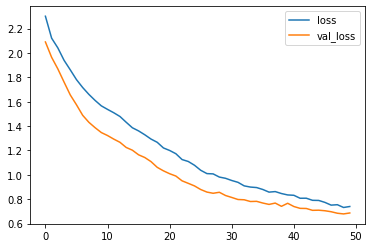

In [23]:
pd.DataFrame(loss.history)[['loss', 'val_loss']].plot()

# **CNN** (konvoliuciniai neuroniniai tinklai)



Šis modelis gaunasi pats tiksliausias, todėl jį ir naudosime.

In [24]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape=[50,50,1])) #conv2 naudojamas gauti aukštą tikslumą paveiksliuko atpažinime
model.add(keras.layers.BatchNormalization(axis=-1)) #leidžia kiekvienam sluoksniui mokytis nepriklausant nuo kitų sluoksnių, normalizuoja buvusių sluoksnių rezultatus
model.add(keras.layers.MaxPooling2D(pool_size=(2,2))) #sumažina input dydį
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu'))
model.add(keras.layers.BatchNormalization(axis=-1))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 22, 22, 32)       128       
 hNormalization)                                                 
                                                      

In [25]:
loss = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20
219/219 [==============================] - 11s 14ms/step - loss: 1.2011 - accuracy: 0.5153 - val_loss: 2.1725 - val_accuracy: 0.1970
Epoch 2/20
219/219 [==============================] - 2s 11ms/step - loss: 0.5197 - accuracy: 0.8081 - val_loss: 2.6142 - val_accuracy: 0.1717
Epoch 3/20
219/219 [==============================] - 3s 11ms/step - loss: 0.2482 - accuracy: 0.9336 - val_loss: 1.3524 - val_accuracy: 0.5137
Epoch 4/20
219/219 [==============================] - 3s 11ms/step - loss: 0.1543 - accuracy: 0.9629 - val_loss: 0.3348 - val_accuracy: 0.9053
Epoch 5/20
219/219 [==============================] - 3s 12ms/step - loss: 0.1127 - accuracy: 0.9716 - val_loss: 0.2667 - val_accuracy: 0.9363
Epoch 6/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0869 - accuracy: 0.9770 - val_loss: 0.2783 - val_accuracy: 0.9397
Epoch 7/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0613 - accuracy: 0.9821 - val_loss: 0.2626 - val_accuracy: 0.957

In [26]:
pred=model.predict(X_test).argmax(axis=1)
print('Test set accuracy - {0:.02%}'.format((pred==y_test).mean()))

Test set accuracy - 95.77%


In [27]:
model.save('model.h5')

In [28]:
model = keras.models.load_model('model.h5')
evaluate('flatland_train.data', model)

0.9836

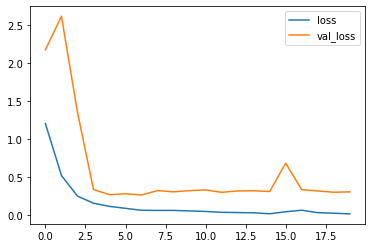

In [29]:
pd.DataFrame(loss.history)[['loss', 'val_loss']].plot()

In [30]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape=[50,50,1])) #conv2 naudojamas gauti aukštą tikslumą paveiksliuko atpažinime
model.add(keras.layers.BatchNormalization(axis=-1)) #leidžia kiekvienam sluoksniui mokytis nepriklausant nuo kitų sluoksnių, normalizuoja buvusių sluoksnių rezultatus
model.add(keras.layers.MaxPooling2D(pool_size=(2,2))) #sumažina input dydį
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_2 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 18432)             0         
                                                                 
 dense_21 (Dense)            (None, 64)                1179712   
                                                                 
 dense_22 (Dense)            (None, 32)               

In [32]:
loss = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20
219/219 [==============================] - 3s 10ms/step - loss: 1.5735 - accuracy: 0.4206 - val_loss: 1.6318 - val_accuracy: 0.3167
Epoch 2/20
219/219 [==============================] - 2s 11ms/step - loss: 0.8180 - accuracy: 0.6823 - val_loss: 1.1240 - val_accuracy: 0.5137
Epoch 3/20
219/219 [==============================] - 2s 11ms/step - loss: 0.5147 - accuracy: 0.8121 - val_loss: 0.6335 - val_accuracy: 0.7517
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.3613 - accuracy: 0.8657 - val_loss: 0.5537 - val_accuracy: 0.8013
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.2596 - accuracy: 0.9057 - val_loss: 0.6220 - val_accuracy: 0.8040
Epoch 6/20
219/219 [==============================] - 2s 11ms/step - loss: 0.1925 - accuracy: 0.9347 - val_loss: 0.5409 - val_accuracy: 0.8350
Epoch 7/20
219/219 [==============================] - 2s 11ms/step - loss: 0.1243 - accuracy: 0.9627 - val_loss: 0.6800 - val_accuracy: 0.8070
E

In [33]:
pred=model.predict(X_test).argmax(axis=1)
print('Test set accuracy - {0:.02%}'.format((pred==y_test).mean()))

Test set accuracy - 85.60%


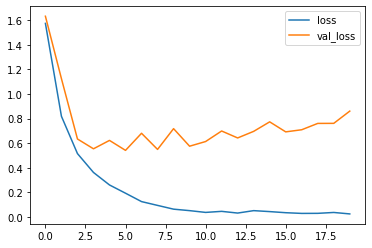

In [34]:
pd.DataFrame(loss.history)[['loss', 'val_loss']].plot()

In [35]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape=[50,50,1])) #conv2 naudojamas gauti aukštą tikslumą paveiksliuko atpažinime
model.add(keras.layers.BatchNormalization(axis=-1)) #leidžia kiekvienam sluoksniui mokytis nepriklausant nuo kitų sluoksnių, normalizuoja buvusių sluoksnių rezultatus
model.add(keras.layers.MaxPooling2D(pool_size=(2,2))) #sumažina input dydį
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape=[50,50,1])) #conv2 naudojamas gauti aukštą tikslumą paveiksliuko atpažinime
model.add(keras.layers.BatchNormalization(axis=-1)) #leidžia kiekvienam sluoksniui mokytis nepriklausant nuo kitų sluoksnių, normalizuoja buvusių sluoksnių rezultatus
model.add(keras.layers.MaxPooling2D(pool_size=(2,2))) #sumažina input dydį
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape=[50,50,1])) #conv2 naudojamas gauti aukštą tikslumą paveiksliuko atpažinime
model.add(keras.layers.BatchNormalization(axis=-1)) #leidžia kiekvienam sluoksniui mokytis nepriklausant nuo kitų sluoksnių, normalizuoja buvusių sluoksnių rezultatus
model.add(keras.layers.MaxPooling2D(pool_size=(2,2))) #sumažina input dydį
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_3 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 22, 22, 32)        9248      
                                                                 
 batch_normalization_4 (Batc  (None, 22, 22, 32)       128       
 hNormalization)                                                 
                                                      

In [37]:
loss = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20
219/219 [==============================] - 4s 14ms/step - loss: 1.2833 - accuracy: 0.5044 - val_loss: 2.1365 - val_accuracy: 0.1997
Epoch 2/20
219/219 [==============================] - 3s 12ms/step - loss: 0.3887 - accuracy: 0.8757 - val_loss: 3.8578 - val_accuracy: 0.1547
Epoch 3/20
219/219 [==============================] - 3s 12ms/step - loss: 0.2238 - accuracy: 0.9444 - val_loss: 0.8224 - val_accuracy: 0.6640
Epoch 4/20
219/219 [==============================] - 3s 12ms/step - loss: 0.1839 - accuracy: 0.9551 - val_loss: 0.2141 - val_accuracy: 0.9550
Epoch 5/20
219/219 [==============================] - 3s 13ms/step - loss: 0.1340 - accuracy: 0.9710 - val_loss: 0.1803 - val_accuracy: 0.9697
Epoch 6/20
219/219 [==============================] - 3s 12ms/step - loss: 0.1327 - accuracy: 0.9659 - val_loss: 0.2976 - val_accuracy: 0.9237
Epoch 7/20
219/219 [==============================] - 3s 13ms/step - loss: 0.1072 - accuracy: 0.9741 - val_loss: 0.2407 - val_accuracy: 0.9410

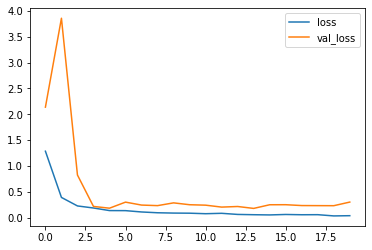

In [38]:
pd.DataFrame(loss.history)[['loss', 'val_loss']].plot()

In [39]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape=[50,50,1])) #conv2 naudojamas gauti aukštą tikslumą paveiksliuko atpažinime
model.add(keras.layers.BatchNormalization(axis=-1)) #leidžia kiekvienam sluoksniui mokytis nepriklausant nuo kitų sluoksnių, normalizuoja buvusių sluoksnių rezultatus
model.add(keras.layers.MaxPooling2D(pool_size=(2,2))) #sumažina input dydį
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape=[50,50,1])) #conv2 naudojamas gauti aukštą tikslumą paveiksliuko atpažinime
model.add(keras.layers.BatchNormalization(axis=-1)) #leidžia kiekvienam sluoksniui mokytis nepriklausant nuo kitų sluoksnių, normalizuoja buvusių sluoksnių rezultatus
model.add(keras.layers.MaxPooling2D(pool_size=(2,2))) #sumažina input dydį
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 22, 22, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 22, 22, 32)       128       
 hNormalization)                                                 
                                                      

In [40]:
loss = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20
219/219 [==============================] - 4s 14ms/step - loss: 1.1610 - accuracy: 0.5431 - val_loss: 3.5144 - val_accuracy: 0.1830
Epoch 2/20
219/219 [==============================] - 3s 13ms/step - loss: 0.4810 - accuracy: 0.8304 - val_loss: 7.6736 - val_accuracy: 0.1847
Epoch 3/20
219/219 [==============================] - 3s 12ms/step - loss: 0.2447 - accuracy: 0.9279 - val_loss: 2.8451 - val_accuracy: 0.3617
Epoch 4/20
219/219 [==============================] - 3s 12ms/step - loss: 0.1370 - accuracy: 0.9673 - val_loss: 0.4177 - val_accuracy: 0.8763
Epoch 5/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0923 - accuracy: 0.9764 - val_loss: 0.3179 - val_accuracy: 0.9033
Epoch 6/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0691 - accuracy: 0.9813 - val_loss: 0.2172 - val_accuracy: 0.9633
Epoch 7/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0620 - accuracy: 0.9833 - val_loss: 0.3280 - val_accuracy: 0.9290

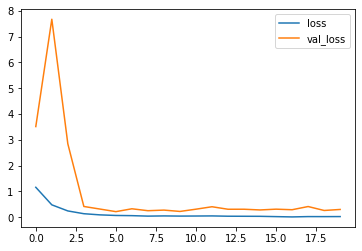

In [41]:
pd.DataFrame(loss.history)[['loss', 'val_loss']].plot()

In [42]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape=[50,50,1])) #conv2 naudojamas gauti aukštą tikslumą paveiksliuko atpažinime
model.add(keras.layers.BatchNormalization(axis=-1)) #leidžia kiekvienam sluoksniui mokytis nepriklausant nuo kitų sluoksnių, normalizuoja buvusių sluoksnių rezultatus
model.add(keras.layers.MaxPooling2D(pool_size=(2,2))) #sumažina input dydį
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape=[50,50,1])) #conv2 naudojamas gauti aukštą tikslumą paveiksliuko atpažinime
model.add(keras.layers.BatchNormalization(axis=-1)) #leidžia kiekvienam sluoksniui mokytis nepriklausant nuo kitų sluoksnių, normalizuoja buvusių sluoksnių rezultatus
model.add(keras.layers.MaxPooling2D(pool_size=(2,2))) #sumažina input dydį
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape=[50,50,1])) #conv2 naudojamas gauti aukštą tikslumą paveiksliuko atpažinime
model.add(keras.layers.BatchNormalization(axis=-1)) #leidžia kiekvienam sluoksniui mokytis nepriklausant nuo kitų sluoksnių, normalizuoja buvusių sluoksnių rezultatus
model.add(keras.layers.MaxPooling2D(pool_size=(2,2))) #sumažina input dydį
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_8 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 22, 22, 32)        9248      
                                                                 
 batch_normalization_9 (Batc  (None, 22, 22, 32)       128       
 hNormalization)                                                 
                                                      

In [44]:
loss = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20
219/219 [==============================] - 5s 13ms/step - loss: 0.9928 - accuracy: 0.6186 - val_loss: 3.0252 - val_accuracy: 0.2237
Epoch 2/20
219/219 [==============================] - 3s 13ms/step - loss: 0.3020 - accuracy: 0.9179 - val_loss: 4.0992 - val_accuracy: 0.1953
Epoch 3/20
219/219 [==============================] - 3s 12ms/step - loss: 0.1794 - accuracy: 0.9596 - val_loss: 1.0695 - val_accuracy: 0.6347
Epoch 4/20
219/219 [==============================] - 3s 13ms/step - loss: 0.1370 - accuracy: 0.9714 - val_loss: 0.1761 - val_accuracy: 0.9693
Epoch 5/20
219/219 [==============================] - 3s 13ms/step - loss: 0.1056 - accuracy: 0.9783 - val_loss: 0.1912 - val_accuracy: 0.9630
Epoch 6/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0993 - accuracy: 0.9746 - val_loss: 0.3013 - val_accuracy: 0.9210
Epoch 7/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0926 - accuracy: 0.9751 - val_loss: 0.1816 - val_accuracy: 0.9713

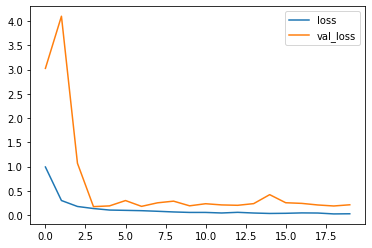

In [45]:
pd.DataFrame(loss.history)[['loss', 'val_loss']].plot()

In [46]:
model.save('model1.h5')